In [1]:
# Parameters
model_classic = None
model_sync = None
model_async = None
include_classification_report = None
include_pics = None

In [2]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:80% !important; }</style>"))

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import subprocess
import os
import numpy as np

def format_timedelta(x, _):
    td = timedelta(seconds=x)
    minutes, remainder = divmod(td.seconds, 60)
    seconds = remainder
    milliseconds = td.microseconds // 1000
    return f"{minutes:02d}:{seconds:02d}:{milliseconds:03d}"

# Plots

## Classic SGD (non distributed)

Classic training time: 31:06:267


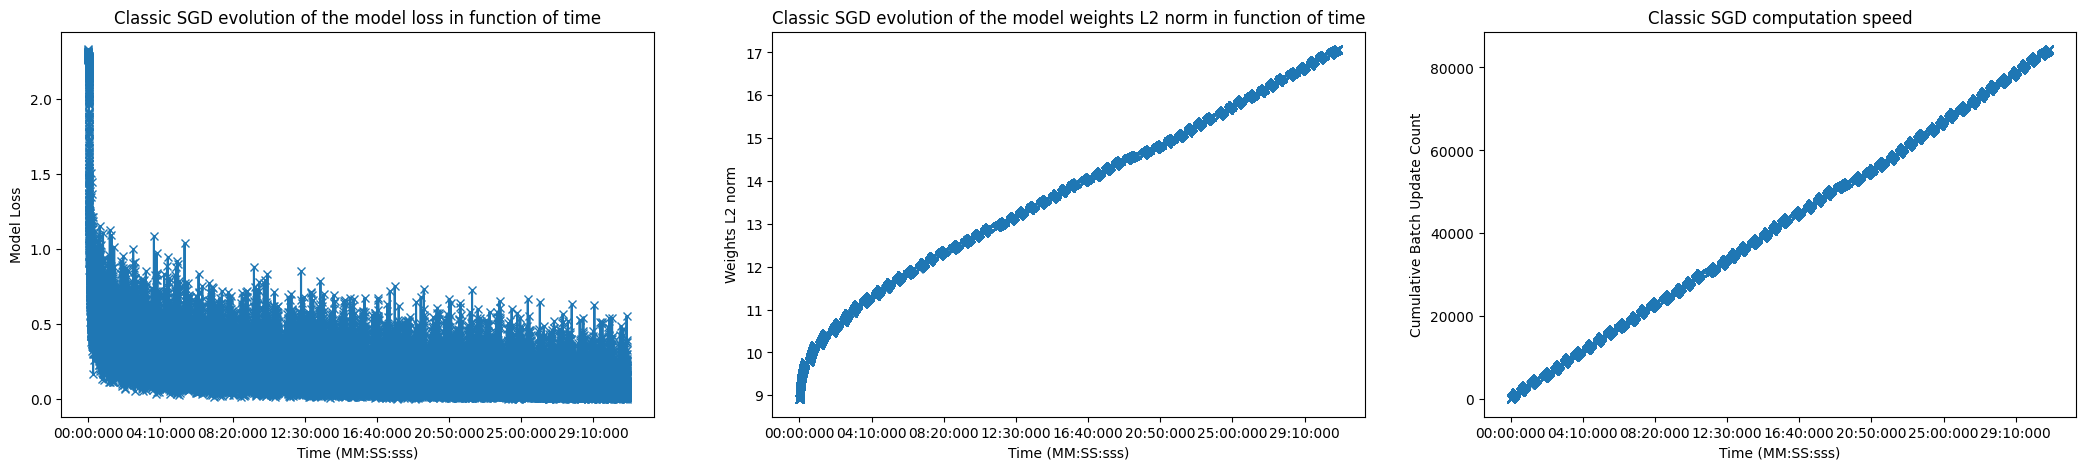

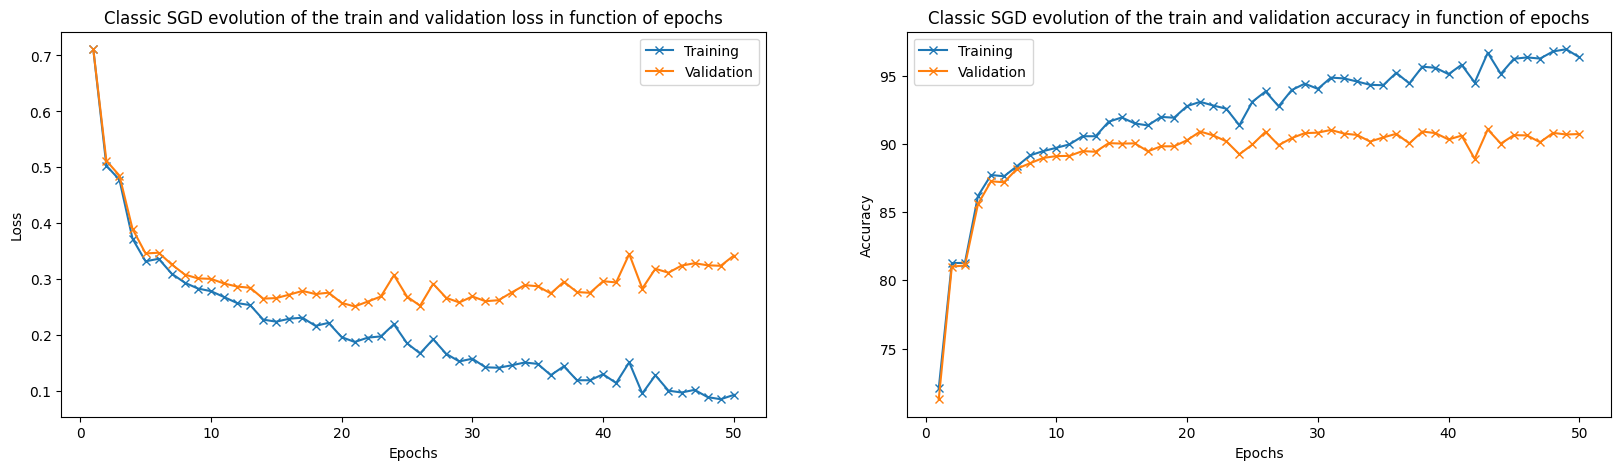

The early stopping epoch is epoch 21


In [15]:
file_name = "log.log"
if (
    # remove model_classic condition if run from notebook
    os.path.exists(file_name)
    # and model_classic is not None
):
    lines = []
    with open("log.log", "r") as log_file:
        # Iterate through each line in the log file
        for line in log_file:
            lines.append(line.split(" - common - "))

    for i, line in enumerate(lines):
        timestamp = datetime.strptime(line[0], "%Y-%m-%d %H:%M:%S,%f")
        lines[i][0] = timestamp

    lines = [line for line in lines if "INFO" not in line[1]]
    val_lines = [line for line in lines if "Train loss:" in line[1]]
    lines = [line for line in lines if "Train loss:" not in line[1]]

    start_time = lines[0][0]
    end_time = lines[-1][0]
    training_time_classic = end_time - start_time

    minutes, remainder = divmod(training_time_classic.seconds, 60)
    seconds = remainder
    milliseconds = training_time_classic.microseconds // 1000
    formatted_training_time_classic = f"{minutes:02d}:{seconds:02d}:{milliseconds:03d}"
    print("Classic training time:", formatted_training_time_classic)  # MM:SS:sss

    for i, line in enumerate(lines):
        lines[i][0] = line[0] - start_time
        lines[i][1] = line[1].split("DEBUG - ")[1].strip()

    model_update_lines = []
    for line in lines:
        splited_text = line[1].split(",")
        model_update_lines.append(
            (
                line[0],
                float(splited_text[0].split(" ")[1]),
                float(splited_text[1].split(" ")[-1]),
                int(splited_text[2].split(" ")[3][1:-1].split("/")[0]),
                int(splited_text[3].split(" ")[-1].split("/")[0]),
            )
        )

    ####### PLOTS #######
    # Create a 1x3 grid of subplots
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(26, 5))

    # First subplot (Model Loss vs Time)
    timedeltas = [line[0].total_seconds() for line in model_update_lines]
    losses = [line[1] for line in model_update_lines]
    axs[0].plot(timedeltas, losses, marker="x")
    axs[0].set_xlabel("Time (MM:SS:sss)")
    axs[0].set_ylabel("Model Loss")
    axs[0].set_title("Classic SGD evolution of the model loss in function of time")
    # Format x-axis tick labels
    formatter = FuncFormatter(format_timedelta)
    axs[0].xaxis.set_major_formatter(formatter)

    # Second subplot (Weights L2 norm vs Time)
    weights_norm = [line[2] for line in model_update_lines]
    axs[1].plot(timedeltas, weights_norm, marker="x")
    axs[1].set_xlabel("Time (MM:SS:sss)")
    axs[1].set_ylabel("Weights L2 norm")
    axs[1].set_title(
        "Classic SGD evolution of the model weights L2 norm in function of time"
    )
    # Format x-axis tick labels
    axs[1].xaxis.set_major_formatter(formatter)

    # Thirst subplot (Cumulative Batch Update Count vs Time)
    batches = [line[3] for line in model_update_lines]
    axs[2].plot(timedeltas, batches, marker="x")
    axs[2].set_xlabel("Time (MM:SS:sss)")
    axs[2].set_ylabel("Cumulative Batch Update Count")
    axs[2].set_title("Classic SGD computation speed")
    # Format x-axis tick labels
    axs[2].xaxis.set_major_formatter(formatter)

    # Display the subplots
    plt.show()

    if len(val_lines) > 0:
        time_offset = val_lines[0][0]
        for idx, v_line in enumerate(val_lines):
            splited_text = v_line[1].split(", ")
            val_lines[idx] = (
                v_line[0] - time_offset,
                float(splited_text[0].split("Train loss: ")[-1]),  # train loss
                float(
                    splited_text[1].split("train accuracy: ")[1].split(" ")[0]
                ),  # train accuracy
                float(splited_text[2].split("val loss: ")[-1]),  # val loss
                float(
                    splited_text[3].split("val accuracy: ")[1].split(" ")[0]
                ),  # val accuracy
            )
        
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
        timedeltas = [line[0].total_seconds() for line in val_lines]
        tr_losses = [line[1] for line in val_lines]
        tr_acc = [line[2] for line in val_lines]
        val_losses = [line[3] for line in val_lines]
        val_acc = [line[4] for line in val_lines]
        # First subplot (Model Loss vs Time)
        """axs[0].plot(timedeltas, tr_losses, marker="x", label="Training")
        axs[0].plot(timedeltas, val_losses, marker="x", label="Validation")
        axs[0].set_xlabel("Time (MM:SS:sss)")
        axs[0].set_ylabel("Loss")
        axs[0].set_title(
            "Classic SGD evolution of the train and validation loss in function of time"
        )
        # Format x-axis tick labels
        formatter = FuncFormatter(format_timedelta)
        axs[0].xaxis.set_major_formatter(formatter)
        axs[0].legend()
        # Second subplot (Weights L2 norm vs Time)
        axs[1].plot(timedeltas, tr_acc, marker="x", label="Training")
        axs[1].plot(timedeltas, val_acc, marker="x", label="Validation")
        axs[1].set_xlabel("Time (MM:SS:sss)")
        axs[1].set_ylabel("Accuracy")
        axs[1].set_title(
            "Classic SGD evolution of the train and validation accuracy in function of time"
        )
        # Format x-axis tick labels
        formatter = FuncFormatter(format_timedelta)
        axs[1].xaxis.set_major_formatter(formatter)
        axs[1].legend()"""

        epochs = list(range(1, len(val_lines) + 1))
        epoch_opt = np.argmin(val_losses) + 1
        print(f"The early stopping epoch is epoch {epoch_opt}.")
        
        # First subplot (Model Loss vs epochs)
        axs[0].plot(epochs, tr_losses, marker="x", label="Training")
        axs[0].plot(epochs, val_losses, marker="x", label="Validation")
        axs[0].set_xlabel("Epochs")
        axs[0].set_ylabel("Loss")
        axs[0].set_title(
            "Classic SGD evolution of the train and validation loss in function of epochs"
        )
        axs[0].legend()
        # Second subplot (Weights L2 norm vs epochs)
        axs[1].plot(epochs, tr_acc, marker="x", label="Training")
        axs[1].plot(epochs, val_acc, marker="x", label="Validation")
        axs[1].set_xlabel("Epochs")
        axs[1].set_ylabel("Accuracy")
        axs[1].set_title(
            "Classic SGD evolution of the train and validation accuracy in function of epochs"
        )
        axs[1].legend()

        # Display the subplots
        plt.show()
        
        

In [23]:
min_loss = float('inf')
early_stop_epoch = 0
patience = 6  # specify your desired patience
counter = 0

for epoch in range(len(val_losses)):
    if val_losses[epoch] < min_loss:
        min_loss = val_losses[epoch]
        early_stop_epoch = epoch
        counter = 0  # reset counter
    elif val_losses[epoch] > min_loss:
        # Count epochs with no improvement
        counter += 1
        # Stop if validation loss is increasing for a number of epochs specified by patience
        if counter >= patience:
            break

print(f'Early stopping epoch: {early_stop_epoch + 1}, Validation loss: {min_loss}')


Early stopping epoch: 21, Validation loss: 0.25136173495650294


## Synchronous SGD

In [ ]:
file_name = "log_sync.log"
if os.path.exists(file_name) and model_sync is not None:
    lines = []
    with open("log_sync.log", "r") as log_file:
        # Iterate through each line in the log file
        for line in log_file:
            lines.append(line.split(" - common - "))

    for i, line in enumerate(lines):
        timestamp = datetime.strptime(line[0], "%Y-%m-%d %H:%M:%S,%f")
        lines[i][0] = timestamp

    nb_workers = int(
        (lines[0][1].split("with ")[1]).split(" workers")[0]
    )  # extract from first line

    lines = [line for line in lines if "INFO" not in line[1]]
    val_lines = [line for line in lines if "Train loss:" in line[1]]
    lines = [line for line in lines if "Train loss:" not in line[1]]

    lines = lines[nb_workers:]

    start_time = lines[0][0]
    end_time = lines[-1][0]
    training_time_sync = end_time - start_time

    minutes, remainder = divmod(training_time_sync.seconds, 60)
    seconds = remainder
    milliseconds = training_time_sync.microseconds // 1000
    formatted_training_time_sync = f"{minutes:02d}:{seconds:02d}:{milliseconds:03d}"
    print("Synchronous training time:", formatted_training_time_sync)  # MM:SS:sss

    for i, line in enumerate(lines):
        lines[i][0] = line[0] - start_time
        lines[i][1] = line[1].split("DEBUG - ")[1].strip()

    model_loss_lines = []
    worker_update_lines = []
    for i, line in enumerate(lines):
        if "PS updated model, " in line[1]:
            # timedetla, model loss
            model_loss_lines.append(
                (
                    line[0],
                    float(line[1].split(",")[1].split(" ")[-1]),
                    float(line[1].split(",")[2].split(" ")[-1]),
                )
            )
        elif "PS got " in line[1]:
            splited_text = (line[1].split("from ")[1]).split(" ")
            # timedelta, worker id, batch count, epoch
            worker_update_lines.append(
                (
                    line[0],
                    int(splited_text[0].split("_")[1][:-1]),
                    int(splited_text[2].split("/")[0][1:]),
                    int(splited_text[-1].split("/")[0]),
                )
            )

    ####### PLOTS #######
    # Create a 1x2 grid of subplots
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(26, 5))

    # First subplot (Model Loss vs Time)
    timedeltas = [line[0].total_seconds() for line in model_loss_lines]
    losses = [line[1] for line in model_loss_lines]
    weights_norm = [line[2] for line in model_loss_lines]
    axs[0].plot(timedeltas, losses, marker="x")
    axs[0].set_xlabel("Time (MM:SS:sss)")
    axs[0].set_ylabel("Model Loss")
    axs[0].set_title("Synchronous SGD evolution of the model loss in function of time")
    # Format x-axis tick labels
    formatter = FuncFormatter(format_timedelta)
    axs[0].xaxis.set_major_formatter(formatter)

    # Second subplot (Weights L2 norm vs Time)
    axs[1].plot(timedeltas, weights_norm, marker="x")
    axs[1].set_xlabel("Time (MM:SS:sss)")
    axs[1].set_ylabel("Weights L2 norm")
    axs[1].set_title(
        "Synchronous SGD evolution of the model weights L2 norm in function of time"
    )
    # Format x-axis tick labels
    formatter = FuncFormatter(format_timedelta)
    axs[1].xaxis.set_major_formatter(formatter)

    # Third subplot (Cumulative Batch Update Count vs Time)
    worker_cumulative_updates = {}
    for line in worker_update_lines:
        td, worker_id, batch_count, epoch = line
        worker_cumulative_updates.setdefault(worker_id, []).append((td, batch_count))

    for worker_id, updates in worker_cumulative_updates.items():
        x = [td.total_seconds() for td, _ in updates]
        y = [batch_count for _, batch_count in updates]
        axs[2].plot(x, y, label=f"Worker {worker_id}", marker="x")

    axs[2].set_xlabel("Time (MM:SS:sss)")
    axs[2].set_ylabel("Cumulative Batch Update Count")
    axs[2].set_title("Synchronous SGD workers speed comparison")
    axs[2].legend()

    # Format x-axis tick labels
    axs[1].xaxis.set_major_formatter(formatter)

    # Display the subplots
    plt.show()

    if len(val_lines) > 0:
        time_offset = val_lines[0][0]
        for idx, v_line in enumerate(val_lines):
            splited_text = v_line[1].split(", ")
            val_lines[idx] = (
                v_line[0] - time_offset,
                float(splited_text[0].split("Train loss: ")[-1]),  # train loss
                float(
                    splited_text[1].split("train accuracy: ")[1].split(" ")[0]
                ),  # train accuracy
                float(splited_text[2].split("val loss: ")[-1]),  # val loss
                float(
                    splited_text[3].split("val accuracy: ")[1].split(" ")[0]
                ),  # val accuracy
            )
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
        timedeltas = [line[0].total_seconds() for line in val_lines]
        tr_losses = [line[1] for line in val_lines]
        tr_acc = [line[2] for line in val_lines]
        val_losses = [line[3] for line in val_lines]
        val_acc = [line[4] for line in val_lines]
        # First subplot (Model Loss vs Time)
        axs[0].plot(timedeltas, tr_losses, marker="x", label="Training")
        axs[0].plot(timedeltas, val_losses, marker="x", label="Validation")
        axs[0].set_xlabel("Time (MM:SS:sss)")
        axs[0].set_ylabel("Loss")
        axs[0].set_title(
            "Synchronous SGD evolution of the train and validation loss in function of time"
        )
        # Format x-axis tick labels
        formatter = FuncFormatter(format_timedelta)
        axs[0].xaxis.set_major_formatter(formatter)
        axs[0].legend()
        # Second subplot (Weights L2 norm vs Time)
        axs[1].plot(timedeltas, tr_acc, marker="x", label="Training")
        axs[1].plot(timedeltas, val_acc, marker="x", label="Validation")
        axs[1].set_xlabel("Time (MM:SS:sss)")
        axs[1].set_ylabel("Accuracy")
        axs[1].set_title(
            "Synchronous SGD evolution of the train and validation accuracy in function of time"
        )
        # Format x-axis tick labels
        formatter = FuncFormatter(format_timedelta)
        axs[1].xaxis.set_major_formatter(formatter)
        axs[1].legend()

        # Display the subplots
        plt.show()

## Asynchronous SGD

In [ ]:
file_name = "log_async.log"
if os.path.exists(file_name) and model_async is not None:
    lines = []
    with open("log_async.log", "r") as log_file:
        # Iterate through each line in the log file
        for line in log_file:
            lines.append(line.split(" - common - "))

    for i, line in enumerate(lines):
        timestamp = datetime.strptime(line[0], "%Y-%m-%d %H:%M:%S,%f")
        lines[i][0] = timestamp

    nb_workers = int(
        (lines[0][1].split("with ")[1]).split(" workers")[0]
    )  # extract from first line

    lines = [line for line in lines if "INFO" not in line[1]]
    lines = lines[nb_workers:]

    start_time = lines[0][0]
    end_time = lines[-1][0]
    training_time_async = end_time - start_time

    minutes, remainder = divmod(training_time_async.seconds, 60)
    seconds = remainder
    milliseconds = training_time_async.microseconds // 1000
    formatted_training_time_async = f"{minutes:02d}:{seconds:02d}:{milliseconds:03d}"
    print("Asynchronous training time:", formatted_training_time_async)  # MM:SS:sss

    for i, line in enumerate(lines):
        lines[i][0] = line[0] - start_time
        lines[i][1] = line[1].split("DEBUG - ")[1].strip()

    worker_update_lines = []
    for i, line in enumerate(lines):
        if "PS updated model, worker loss: " in line[1]:
            splited_text = (line[1].split("PS updated model, worker loss: "))[1].split(
                " "
            )
            worker_update_lines.append(
                (
                    line[0],
                    float(splited_text[0]),
                    float(splited_text[-1]),
                    int(splited_text[1].split("_")[1].split(")")[0]),
                )
            )

    ####### PLOTS #######
    # Create a 1x2 grid of subplots
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(26, 5))

    # First subplot (Worker Loss vs Time)
    worker_losses = {}
    for line in worker_update_lines:
        td, worker_loss, _, worker_id = line
        worker_losses.setdefault(worker_id, []).append((td, worker_loss))

    for worker_id, losses in worker_losses.items():
        x = [td.total_seconds() for td, _ in losses]
        y = [worker_loss for _, worker_loss in losses]
        axs[0].plot(x, y, label=f"Worker {worker_id}", marker="x")
    axs[0].set_xlabel("Time (MM:SS:sss)")
    axs[0].set_ylabel("Worker Loss")
    axs[0].set_title("Asynchronous SGD evolution of worker loss in function of time")
    axs[0].legend()
    # Format x-axis tick labels
    formatter = FuncFormatter(format_timedelta)
    axs[0].xaxis.set_major_formatter(formatter)

    # Second subplot (Weigh L2 norm vs Time)
    weights_norms = {}
    for line in worker_update_lines:
        td, _, worker_w_norm, worker_id = line
        weights_norms.setdefault(worker_id, []).append((td, worker_w_norm))

    for worker_id, weight_norm in weights_norms.items():
        x = [td.total_seconds() for td, _ in weight_norm]
        y = [w_norm for _, w_norm in weight_norm]
        axs[1].plot(x, y, label=f"Worker {worker_id}", marker="x")
    axs[1].set_xlabel("Time (MM:SS:sss)")
    axs[1].set_ylabel("Weights L2 norm")
    axs[1].set_title(
        "Asynchronous SGD evolution of the weights L2 norm in function of time"
    )
    axs[1].legend()
    # Format x-axis tick labels
    formatter = FuncFormatter(format_timedelta)
    axs[1].xaxis.set_major_formatter(formatter)

    # Third subplot (Cumulative Batch Update Count vs Time)
    worker_cumulative_updates = {}
    for line in worker_update_lines:
        td, _, _, worker_id = line
        worker_cumulative_updates.setdefault(worker_id, []).append(td)
    for worker_id, updates in worker_cumulative_updates.items():
        x = [td.total_seconds() for td in updates]
        y = list(range(1, len(updates) + 1))
        axs[2].plot(x, y, label=f"Worker {worker_id}", marker="x")
    axs[2].set_xlabel("Time (MM:SS:sss)")
    axs[2].set_ylabel("Cumulative Batch Update Count")
    axs[2].set_title("Asynchronous SGD workers speed comparison")
    axs[2].legend()
    # Format x-axis tick labels
    axs[2].xaxis.set_major_formatter(formatter)

    # Display the subplots
    plt.show()

# Train/Test Performance

## Classic SGD

In [ ]:
if model_classic is not None:
    command = ["python3", "test_model.py", model_classic, "--training_time"]
    if include_classification_report is not None:
        command.append("--classification_report")
    if include_pics is not None:
        command.append("--pics")
    subprocess.run(command)

## Synchronous SGD

In [ ]:
if model_sync is not None:
    command = ["python3", "test_model.py", model_sync, "--training_time"]
    if include_classification_report is not None:
        command.append("--classification_report")
    if include_pics is not None:
        command.append("--pics")
    subprocess.run(command)

## Asynchronous SGD

In [ ]:
if model_async is not None:
    command = ["python3", "test_model.py", model_async, "--training_time"]
    if include_classification_report is not None:
        command.append("--classification_report")
    if include_pics is not None:
        command.append("--pics")
    subprocess.run(command)